## Prompt Chaining
Prompt chaining is a technique in natural language processing where multiple prompts are sequenced together to guide a model through a complex task or reasoning process. Instead of relying on a single prompt to achieve a desired outcome, prompt chaining breaks the task into smaller, manageable steps, with each step building on the previous one. This approach can improve accuracy, coherence, and control when working with large language models. LangGraph, is a framework designed to facilitate structured interactions with language models, making it an excellent tool for implementing prompt chaining. It allows you to define a graph of nodes (representing individual prompts or tasks) and edges (representing the flow of information between them). This structure enables dynamic, multi-step conversations or workflows, where the output of one node can feed into the input of the next.

In [ ]:

#Read the .env file and copy everything inside it into the system environment.
from dotenv import load_dotenv
load_dotenv()

#After this line:
#  1. .env variables are now inside OS environment memory
#  2. Python can access them

os.getenv("GROQ_API_KEY")
# “Ask the operating system: do you have a variable named GROQ_API_KEY"

## final
# We need load_dotenv() because Python cannot read .env files by itself, and os.getenv() can only read variables that are already loaded into the operating system environment.


In [19]:

import os
from dotenv import load_dotenv

from typing_extensions import TypedDict
from langchain_groq import ChatGroq

load_dotenv()
os.environ["GROQ_API_kEY"]= os.getenv("GROQ_API_kEY")

# define an llm model
llm=ChatGroq(model="llama-3.1-8b-instant")


# How graph looks like
class State(TypedDict):
    topic:str
    story:str
    improved_story:str
    final_story:str
       

In [20]:
def generate_story(state:State):
    msg=llm.invoke(f"Write a one line story about:{state['topic']}")
    return{"story":msg.content}


def check_conflict(state:State):
    if "?" in state["story"] or "!" in state["story"]:
        return "Fail"
    return "Pass"

def improved_story(state:State):
    msg=llm.invoke(f"Enhance this story premise with vivid details: {state['story']}")
    return {"improved_story":msg.content}

def polish_story(state:State):
    msg=llm.invoke(f"Add an unexpected twist to this story premise: {state['improved_story']}")
    return {"final_story":msg.content}

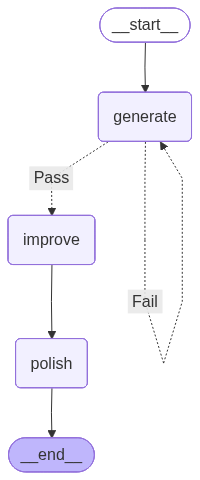

In [24]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image

#Build the graph
graph = StateGraph(State)

graph.add_node("generate", generate_story)
graph.add_node("improve", improved_story)
graph.add_node("polish", polish_story)

## Define the edges
graph.add_edge(START, "generate")
graph.add_conditional_edges("generate", check_conflict, {"Pass":"improve", "Fail":"generate"})
graph.add_edge("improve", "polish")
graph.add_edge("polish", END)

# Compile the graph
compiled_graph = graph.compile()

# Visualize the graph (for Jupyter notebook)
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

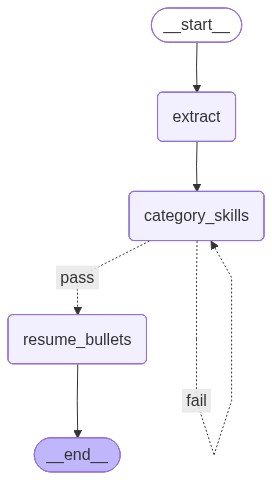

In [12]:
#Example Prompt Chaining"
#"Resume Bullet Generator"

#Goal : Given a job description, the system should generate resume bullet points tailored for that job.

#Steps  1. Job description   2.Extract Skills and tools   3.Group into categories  4.Generate each category bullets 


import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from langgraph.graph import START,END,StateGraph
from IPython.display import display,Image

load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="llama-3.1-8b-instant")

class Resume(TypedDict):
    job_description:str
    skills:str
    category_skills:str
    generate_resume_bullets:str
    
    
def Extract_Skills(state:Resume):
    msg=llm.invoke(f"Extract key technical skills from this job description: {state["job_description"]}")   
    return{"skills":msg.content}

def Category_Skills(state:Resume):
    msg=llm.invoke(f"Group these skills into categories:{state["skills"]}")
    return{"category_skills":msg.content}

def check_conflict(state:Resume):
    text = state["category_skills"] 
    
    if ":" in text and "\n" in text:
        return "pass"
    return "fail"

def resume_bullets(state:Resume):
    msg=llm.invoke(f"Generate clean bullets of these category skills: {state["category_skills"]}")
    return{"generate_resume_bullets":msg.content} 


graph= StateGraph(Resume)

graph.add_node("extract",Extract_Skills)
graph.add_node("category_skills",Category_Skills)
graph.add_node("resume_bullets",resume_bullets)

graph.add_edge(START,"extract")
graph.add_edge("extract","category_skills")
graph.add_conditional_edges("category_skills",check_conflict,{"pass":"resume_bullets","fail":"category_skills"})
graph.add_edge("resume_bullets",END)


compiled_graph = graph.compile()

# Visualize the graph (for Jupyter notebook)
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))


In [13]:
result=compiled_graph.invoke(
    {"job_description": "I am a Full Stack devloper with expertise in Nextjs 15 , React19 , Nodejs , ExpressJS, FastApi, Gitbash, Postman, PostgreSQL"})
    
 
print(result["generate_resume_bullets"])    
    


Here are the clean bullets categorized by technical skills:

**Programming Languages**
- JavaScript
- Python

**Front-end Development**
- Nextjs (version 15)
- React (version 19)

**Back-end Development**
- Nodejs
- ExpressJS
- FastApi (Python-based API framework)

**Database Management**
- PostgreSQL (relational database management system)

**APIs and Frameworks**
- ExpressJS (back-end framework for Nodejs)
- FastApi (Python-based API framework)

**Development Tools and Version Control**
- Gitbash (a Git client with a bash-like interface)
- Postman (API testing and development tool)
